# Face mask detection 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import cv2
import seaborn as sns
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
tain_data_path = './data/train/maksssksksss'
test_data_path = './data/test/maksssksksss'
data_path = './data/annotations/maksssksksss'
class_names = {0:'with_mask', 1:'without_mask', 2:'mask_weared_incorrect'}

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/CV/Project'

/content/gdrive/MyDrive/CV/Project


#Finding bounding boxes and saving it into dataframes

In [5]:
def load_pascal_annotation(filename, index):
    """
    Load image and bounding boxes info from XML file in the PASCAL VOC
    format.
    """
    file = os.path.join(data_path + index + '.xml')
    filename = 'maksssksksss'+index
    tree = ET.parse(file)
    root = tree.getroot()
    send_obj = {}
    arr_send = []
    send_obj['width'] = width = int(root.find('size').find('width').text)
    send_obj['height'] = height = int(root.find('size').find('height').text)
    send_obj['depth'] = depth = int(root.find('size').find('depth').text)
    # Load object bounding boxes into a data frame
    for obj in root.iter('object'):
      send_obj['xmin'] = int(obj.find('bndbox').find('xmin').text)
      send_obj['ymin'] = int(obj.find('bndbox').find('ymin').text)
      send_obj['xmax'] = int(obj.find('bndbox').find('xmax').text)
      send_obj['ymax'] = int(obj.find('bndbox').find('ymax').text)
      send_obj['filename'] = filename
      send_obj['label'] = obj.find('name').text
      send_obj = {}
      arr_send.append(send_obj)
        
    return arr_send



In [ ]:

dataset = []
for ele in range(853):
  anno = load_pascal_annotation(tain_data_path, str(ele))
  dataset.append(anno)

# print(dataset)
full_dataset = sum(dataset, [])
# print(full_dataset)
df = pd.DataFrame(full_dataset)
df.shape

In [7]:
df["label"].value_counts()


with_mask                2534
without_mask              598
mask_weared_incorrect      87
Name: label, dtype: int64

#Plot showing the number of with_mask, without_mask, mask_weared_incorrect

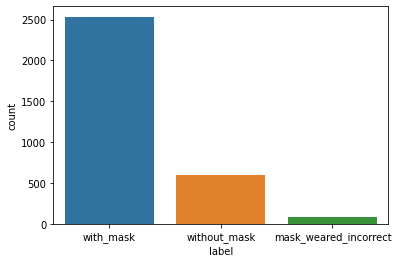

In [8]:
sns.countplot(x=df["label"])
plt.show()


In [9]:
def load_data(path, img_size, num_files, batch_size=16, shuffle=False, augment=False, is_color=False, zero_centered=False): 

  data = []
  labels = []
  for i in range(num_files[0],num_files[1]):
    img = Image.open(path + str(i) + '.png')
    img_arr = np.array(img)
    img_input = df.loc[df['filename'] == 'maksssksksss' + str(i)]
    for ind in img_input.index:
      img_cropped = img_arr[int(img_input['ymin'][ind]):int(img_input['ymax'][ind]), int(img_input['xmin'][ind]):int(img_input['xmax'][ind]), :3]
      resized_img = cv2.resize(img_cropped, img_size, cv2.INTER_LINEAR)
      img = np.transpose(resized_img, [2, 0, 1])
      data.append(img.astype(np.float)/255*2-1)
      if(img_input['label'][ind] == 'with_mask'):
        labels.append(0)
      elif(img_input['label'][ind] == 'without_mask'):
        labels.append(1)
      else:
        labels.append(2)

  print(len(data))
  print(len(labels))
  if augment: 
          for i in range(len(data)):
            flip_img = cv2.flip(data[i], 1)
            data.append(flip_img)
            labels.append(labels[i])

  if zero_centered:
      mean = np.mean(data, axis=0)
      for index in range(len(data)):
        data[index]-= mean

  # randomly permute (this step is important for training)
  if shuffle:
      bundle = list(zip(data, labels))
      random.shuffle(bundle)
      data, labels = zip(*bundle)
  
  # divide data into minibatches of TorchTensors
  if batch_size > 1:
      batch_data = []
      batch_labels = []
      
      for i in range(int(len(data) / batch_size)):
          minibatch_d = data[i*batch_size: (i+1)*batch_size]
          minibatch_d = np.reshape(minibatch_d, (batch_size, 3, img_size[0], img_size[1]))
          batch_data.append(torch.from_numpy(minibatch_d))

          minibatch_l = labels[i*batch_size: (i+1)*batch_size]
          batch_labels.append(torch.LongTensor(minibatch_l))
      data, labels = batch_data, batch_labels 
  
  return zip(batch_data, batch_labels)



In [10]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch
train_range = [0,801]
test_range = [801,853]


In [11]:
# load training dataset
trainloader_small = list(load_data(tain_data_path, img_size, train_range, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


3079
3079
Finish loading 48 minibatches (batch_size=64) of training samples.


In [12]:

# load testing dataset
testloader_small = list(load_data(test_data_path, img_size, test_range, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


140
140
Finish loading 2 minibatches (batch_size=64) of testing samples.


with_mask


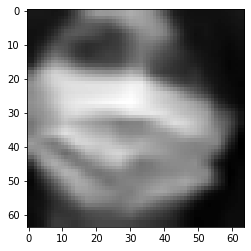

In [13]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][38][0], trainloader_small[0][1][38]
label = int(np.array(label))
print(class_names[label])
imshow(img)

In [14]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  running_loss = 0.0
  loss_arr = []
  accuracy = []
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters)) 
        loss_arr.append(running_loss/iters)
   
    if testloader is not None and ep % eval_epoch == 0:
      acc = evalModel(net, testloader)
      accuracy.append(acc)
  return loss_arr, accuracy

In [15]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  return(float(acc/count))

In [18]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(3, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  

In [19]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
loss, acc = trainModel(net, trainloader_small, train_option, testloader_small)
print(acc)
print(loss)

Epoch: 1 | Iter:    0 | Time: 00:00:10 | Train Loss: 2.8726 | Average Loss: 2.8726 
Epoch: 1 | Iter:   20 | Time: 00:00:11 | Train Loss: 0.2234 | Average Loss: 0.5750 
Epoch: 1 | Iter:   40 | Time: 00:00:11 | Train Loss: 0.3410 | Average Loss: 0.4295 
Accuracy: 0.953125 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:11 | Train Loss: 0.2788 | Average Loss: 0.4023 
Epoch: 2 | Iter:   20 | Time: 00:00:11 | Train Loss: 0.2161 | Average Loss: 0.3484 
Epoch: 2 | Iter:   40 | Time: 00:00:11 | Train Loss: 0.2569 | Average Loss: 0.3157 
Accuracy: 0.914062 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:11 | Train Loss: 0.2471 | Average Loss: 0.3091 
Epoch: 3 | Iter:   20 | Time: 00:00:11 | Train Loss: 0.2197 | Average Loss: 0.2890 
Epoch: 3 | Iter:   40 | Time: 00:00:11 | Train Loss: 0.2340 | Average Loss: 0.2731 
Accuracy: 0.929688 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:11 | Train Loss: 0.1904 | Average Loss: 0.2702 
Epoch: 4 | Iter:   20 | Time: 00:00:11 | Train Loss:

In [ ]:
def plot_graph(array_plot):
  f = plt.figure()
  f.set_figwidth(12)
  f.set_figheight(6)
  plt.clf()
  sns.lineplot(range(len(array_plot)), array_plot, label="Training loss")
  plt.title("Training loss")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

In [ ]:
plot_graph(loss)

In [ ]:
plot_graph(acc)

In [ ]:
# Specify a path
PATH = "./entire_model.pt"
# Save
torch.save(net, PATH)
 
# Load
model = torch.load(PATH)
model.eval()